In [2]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sb
from scipy.spatial.distance import cdist
from scipy.integrate import odeint
import warnings
import sys
from tqdm import tqdm
from ipywidgets import interact
warnings.simplefilter('error')


"""
This program simulated the shock tube with sph 


    - Odeint integration
    - Problems with Verlet integration
    
Autor: Hernan Salinas 
Date_update : 2/21/2021

Reference: https://core.ac.uk/download/pdf/81947104.pdf
Science Direct 14 (2011) 2743–2750
Ref : Computational physics UdeA, 
"""


'\nThis program simulated the shock tube with sph \n\n\n    - Odeint integration\n    - Problems with Verlet integration\n    \nAutor: Hernan Salinas \nDate_update : 2/21/2021\n\nReference: https://core.ac.uk/download/pdf/81947104.pdf\nScience Direct 14 (2011) 2743–2750\nRef : Computational physics UdeA, \n'

# Problems, the shock tube
Shock tube in 1 Dimension without viscous streess and heat.  The shock tube is a long straight tube filled with gas, which is separated by a membrane in two parts with different pressures and densities but are individually in thermodynamic equilibrium. 

When the membrane is taken away the following are produce:
- A schock wave-moves into region of lower density 
- A rarefaction wave(reduction in density)-moves into region of high density
- A contact discontinuity-forms in center and travels inton low density region behind the shock


Parameter of the regions in the tube:
### left region 
$x \leq 0$, $\rho =    1$, $v=0$, $e = 2.500$, $p=1$ $ \Delta x=0.001875 $

### right region 
$x > 0$, $\rho = 0.25$, $v=0$, $e = 1.795$, $p=0.1795$ $ \Delta x=0.0075 $

Parameter:
- $\rho$ : Density
- P : Pressure
- e : Internal energy
- v : velocity
- $\Delta x$ : particle spacing
- m : 0.001875.
- Np: 320 distributed in the hight density region 
- Np: 80 in the low density region 
- [-0.6------------------0.0-----------------------0.6]


We use the following equation of state:

- $p=(\gamma-1)\rho e$
- $c = \sqrt{(\gamma-1)e}$

with $\gamma = 1.4$, the time step to $0.005$ and run the simulation for 40 time steps


## Navier Stokes equation 

- Continuity equation
\begin{equation}
\frac{D \rho}{Dt} = \sum_{j=1}^N m_j (v_j-v_i)\cdot \nabla_i W_{ij}
\end{equation}

or 

\begin{equation}
\rho_i = \sum_{j=1}^N m_j W_{ij}
\end{equation}

- Momentum equation  
\begin{equation}
\frac{D v_i}{Dt} = \sum_{j=1}^N m_j \left( \frac{P_i}{\rho_i^2}+ \frac{P_j}{\rho_j^2}\right) \nabla_i W_{ij}
\end{equation}


- Internal Energy 
\begin{equation}
\frac{D e_i}{Dt} = \sum_{j=1}^N m_j \left( \frac{P_i}{\rho_i^2}+ \frac{P_j}{\rho_j^2} + \Pi_{ij} \right) (v_i-v_j) \cdot \nabla_i W_{ij}\nabla_i W_{ij}
\end{equation}

- Velocity
\begin{equation}
\frac{D x_i}{Dt} = v_i
\end{equation}





## Kernel and its derivative

### Cubic spline

\begin{equation}
 W(R,h)=\alpha_d \left\{ \begin{array}{ll}
         \frac{2}{3} - q^2 +\frac{1}{2}q^3 & \mbox{si $ 0 \leq q < 1 $};\\
         \frac{1}{6}(2 -q)^3 & \mbox{si $1 \leq q < 2$}.\\
 0 & \mbox{si $q \geq 2$ }          \end{array} \right. 
\end{equation}

\begin{equation}
 W'(R,h)=\alpha_d \left\{ \begin{array}{ll}
         (-2 + \frac{3}{2}q)\frac{d\bf{x}}{h^2} & \mbox{si $ 0 \leq q < 1 $};\\
         \frac{1}{2}(2 -q)^2\frac{d\bf{x}}{hr} & \mbox{si $1 \leq q < 2$}.\\
 0 & \mbox{si $q \geq 2$ }          \end{array} \right. 
\end{equation}


- $q= \frac{r_{ij}}{h}=\frac{|\vec{r}_i-\vec{r}_j|}{h}$
- In 1D $\alpha_d = 1/h $
- In 2D $\alpha_d = 15/(7\pi h^2) $
- In 3D $\alpha_d = 3/(2\pi h^3) $


In [21]:
def KernelPolynomial(R,h):
    """
    Input: Radii of particle and h 
    Output: Kernel W
    """ 
    
    
    W0 = 2./(3*h) #1.0# (np.pi * 4 * h** 3) ** (-1)
    q = R/h
    W = 0
    
    if 0 <= q <  1:
        
        W = 1-3/2 *q**2 *( 1- q/2)
    
    elif  1 <= q < 2:
        
        W =  1./4* (2 - q ) ** 3 #(1./4) * (2 - ( q )) ** 3
    
    elif q >= 2:
        
        W = 0
        
    else:
        print("Error kernel Polynomial!",R)
    
    return W


def KernelPolynomial_p(R, h):
    #REvisar si es utlizado
      
    W0 = 2./(3*h**2)# (np.pi * 4 * h** 3) ** (-1)
    #W = 0
    q = R/h
    
    if 0. <= q <  1:
        
        W = -3 * q + 9./4* q**3  #-(3./h) * q + (9./(4*h)) * q **2
    
    elif  1 <= q < 2:
        
        W = - 3./4 *( 2 - q) **2#-(3./(4*h)) * (2 - ( q )) ** 2
    
    elif q >= 2:
        
        W = 0
        
    else:
        print("Error kernel Polynomial!",R)
    
    return W
    
    
    


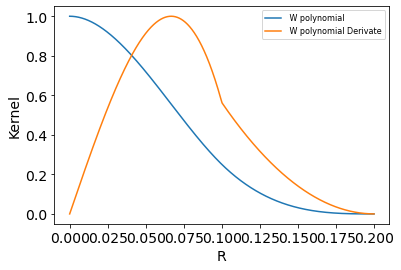

In [22]:
h = 0.1
step =  h /1000
R = np.arange(0, 2*h, step)

#KG = KernelGaussian(R, h) #kernel gaussiano
#KP = kernelPolinomial_(R, h) #kernel gaussiano
KP = np.array([KernelPolynomial(r,h) for r in R]) # kernel polinomial

KP_p = np.array([KernelPolynomial_p(r,h) for r in R]) #derivate of kernel polinomial 

plt.figure(figsize=(6,4))
plt.plot(R, KP/np.max(KP),  label = " W polynomial")
plt.plot(R, KP_p/np.min(KP_p),  label = " W polynomial Derivate")
plt.xlabel("R",  fontsize=14)
plt.ylabel("Kernel", fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 8)
plt.show()

In [24]:
def eos(ρ,e,γ):
    return (γ - 1) * ρ * e

In [25]:
def compute_force_i(i, pos_r, vel, ρ, e,mass,h,NP):
    """
    --Input--
    i  :i-th particle
    pos: vector pos_r
    vel: vector velocity
    ρ   :density 
    P   : Preasure
    mass   : mass
    
    --Output--
    dvdt, ρ, P
    Force the i-th particle
    
    """
    T2  = 0
    T1  = 0
    density = 0
    P     = eos(ρ,e,γ)

    for j in range(0, NP):
        if(i != j):
           
            Πij = 0
            hij = (h[i] + h[j])*0.5
                    
            Rij = pos_r[j] - pos_r[i] #vector
            
            kernel = KernelPolynomial(abs(Rij),hij)
            derivadaKernel = KernelPolynomial_p(abs(Rij),hij)
            
           
            vij    = vel[i] - vel[j]        #vector
           
            #Preasure term
            T1  -= mass[j] *  (P[j] / ρ[j] ** 2 + P[i] / ρ[i] ** 2+Πij) * derivadaKernel 
            T2  += 0.5 *mass[j] *  (P[j] / ρ[j] ** 2 + P[i] / ρ[i] ** 2+Πij)*vij*derivadaKernel
            density+= mass[j]*abs(derivadaKernel)
            
    dvdt = T1
    dedt = T2
    dρdt = density
    return  dvdt,dρdt,dedt


In [26]:
def force_per_particle(pos_r, vel, ρ, e,mass, h,NP):
    dvdt1 = np.zeros(NP)
    dedt1 = np.zeros(NP)
    dρdt1 = np.zeros(NP)


    for i in range(0,NP):
        dvdt1[i], dρdt1[i],dedt1[i] = compute_force_i(i, pos_r, vel, ρ,e, mass,h,NP)
    dxdt1 = vel
    return dxdt1, dvdt1,dρdt1,dedt1



#  Velocity Verlet integration
 

In [27]:
#Verlet
#Parameter 
ρ1 = 1.0
ρ2 = 0.25
e1 = 2.5
e2 = 1.795
γ  = 1.4 
L  = 1.2 #unit


#Position of particles
N1=320
N2=80

#Particles position
x_left  = np.linspace(-0.6,0.0, N1)
x_right = np.linspace(0.0,0.6, N2)

h_left  = (1.2/N1) *np.ones(N1)
h_right = (1.2/N2) *np.ones(N2)

e_left  = e1*np.ones(N1)
e_right = e2*np.ones(N2)

ρ_left = ρ1*np.ones(N1)
ρ_right= ρ2*np.ones(N2)

pos = np.concatenate([x_left,x_right])
h = np.concatenate([h_left,h_right])
e = np.concatenate([e_left,e_right])
ρ = np.concatenate([ρ_left,ρ_right])


NP=len(pos)
m0 = (ρ1 + ρ2) * L / NP
mass = m0*np.ones(NP)/2
vel = np.zeros(NP)

In [28]:
dt = 5E-2
T   = np.arange(0,5, dt/2)

len(T)
T = T[0:80]
n = len(T)


In [29]:
dxdt, dvdt,dρdt,dedt = force_per_particle(pos, vel, ρ, e,mass, h,NP)
#dxdt, dvdt,dρdt,dedt = force_per_particle(x, v, ρ, e,mass, h,NP)

In [30]:
#Inicialization of variables and build array
v_medio   = np.zeros((n, NP))
v_gorro   = np.zeros((n, NP))
ρ_medio   = np.zeros((n, NP))
e_medio   = np.zeros((n, NP))
r         = np.zeros((n, NP))
v         = np.zeros((n, NP))
a         = np.zeros((n, NP))
_ρ_       = np.zeros((n, NP))
_e_       = np.zeros((n, NP))
ρ_p       = np.zeros((n, NP))
e_p       = np.zeros((n, NP))

velocidad = np.zeros((n, NP))

#Initial values/
r[0]    = pos
v[0]    = vel
a[0]    = dvdt
_ρ_[0]  = ρ
_e_[0]  = e

ρ_p[0] = dρdt
e_p[0] = dedt

#_P_[0]  = P_

In [31]:
k=n-2
loop = tqdm(total=k, position=0, leave=False)
for i in range(0, k, 2):
    loop.set_description("loading ...".format(i))
    loop.update(2)
    
    
    v[i + 1] = v[i] + dt * 0.5 * a[i]

    v_gorro[i + 2] = v[i] + dt * 1.0 * a[i]

    _ρ_[i + 1] = _ρ_[i]  +  dt * 0.5 * ρ_p[i]

    _e_[i + 1] = _e_[i]  +  dt * 0.5 * e_p[i]


    r[i + 2]       = r[i] + dt * v[i + 1] 
 #   try:
    dxdt, a[i+2],ρ_p[i+2],e_p[i+2] = force_per_particle(r[i+2], v_gorro[i + 2], _ρ_[i + 1], _e_[i+1],mass, h,NP)
#    except:
#        print("Unexpected error:", sys.exc_info()[0]) 
#        print(i)
#        break
        
    _ρ_[i + 2] = _ρ_[i + 1] + dt*ρ_p[i+2] #+ 0.5*ρ_p[i]
    _e_[i + 2] = _e_[i + 1] + dt*e_p[i+2] #+ 0.5*ρ_p[i]

    v[i + 2] = v[i + 1] + 0.5 * dt * a[i+2] 
     

loading ...: 100%|█████████████████████████████████████████████████████████████████████| 78/78 [01:20<00:00,  1.07s/it]

Text(0, 0.5, 'Density')

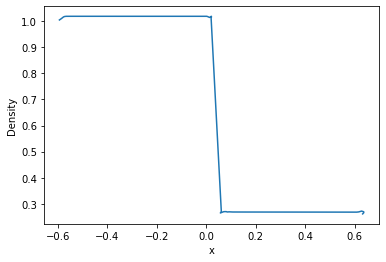

In [34]:
#@interact
#def grap( i = np.arange(180,198 , 2)):
i=62
plt.plot(r[i],_ρ_[i])
plt.xlabel("x")
plt.ylabel("Density")
#plt.ylim(-1,2)
#plt.xlim(-0.6,0.6)
#return plt.figure()
#plt.xlim(1250, 1800)

## Odeint 

In [ ]:
Yini= np.concatenate((x,v,e,ρ))
T   = np.arange(0.,5, 5E-3)
T = T[0:40]
def odesys(Y, t, mass, H,NP):
    
    Yr=Y.reshape((4,NP))

    x = Yr[0]
    v = Yr[1]
    ρ = Yr[2]
    e = Yr[3]
    
    
    dxdt, dvdt,dρdt,dedt = force_per_particle(x, v, ρ, e,mass, H,NP)
    
    return np.concatenate((dxdt,dvdt,dρdt,dedt))


In [ ]:
H=h
Y = odeint(odesys,Yini,T,args = (mass,H,NP))
Yr=Y.reshape((len(T),4,NP))
x=Yr[:,0]
v=Yr[:,1]
ρ =Yr[:,2]
e=Yr[:,3]
plt.figure()
plt.plot(x[-1],ρ[-1])
plt.show()

In [ ]:
#Parameter 
ρ1 = 1.0
ρ2 = 0.25
e1 = 2.5
e2 = 1.795
γ  = 1.4 
L  = 1.2 #unit


#Position of particles
N1=320
N2=80

#Particles position
x_left  = np.linspace(-0.6,0.0, N1)
x_right = np.linspace(0.0,0.6, N2)

h_left  = (1.2/N1) *np.ones(N1)
h_right = (1.2/N2) *np.ones(N2)

e_left  = e1*np.ones(N1)
e_right = e2*np.ones(N2)

ρ_left = ρ1*np.ones(N1)
ρ_right= ρ2*np.ones(N2)

x = np.concatenate([x_left,x_right])
h = np.concatenate([h_left,h_right])
e = np.concatenate([e_left,e_right])
ρ = np.concatenate([ρ_left,ρ_right])


NP=len(x)
m0 = (ρ1 + ρ2) * L / NP
mass = m0*np.ones(NP)/2
v = np.zeros(NP)